# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar
from scipy.optimize import root_scalar
from types import SimpleNamespace

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

%load_ext autoreload
%autoreload 2

from InaguralProject import ExchangeEconomyClass

## Questions

### 1 -  Illustrate the following set in the Edgeworth box

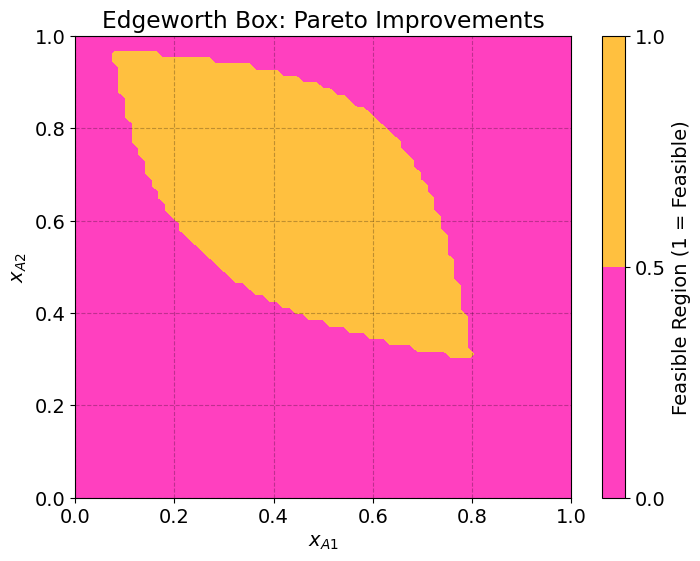

In [3]:
# Constants
alpha = 1/3
beta = 2/3
N = 75
omega_A1 = 0.8
omega_A2 = 0.3

# Initial utilities
def utility_A(x1, x2):
    return x1**alpha * x2**(1-alpha)

def utility_B(x1, x2):
    return x1**beta * x2**(1-beta)

# Initial endowments
uA_initial = utility_A(omega_A1, omega_A2)
omega_B1 = 1 - omega_A1
omega_B2 = 1 - omega_A2
uB_initial = utility_B(omega_B1, omega_B2)

# Edgeworth Box
x_A1_range = np.linspace(0, 1, N)
x_A2_range = np.linspace(0, 1, N)
X_A1, X_A2 = np.meshgrid(x_A1_range, x_A2_range)

# Calculate utilities at each point
UA = utility_A(X_A1, X_A2)
UB = utility_B(1 - X_A1, 1 - X_A2)

# Mask to find combinations where both A and B are at least as well off
pareto_improvements = (UA >= uA_initial) & (UB >= uB_initial)

# Plotting
plt.figure(figsize=(8, 6))
plt.contourf(X_A1, X_A2, pareto_improvements, levels=1, cmap='spring')
plt.title('Edgeworth Box: Pareto Improvements')
plt.xlabel('$x_{A1}$')
plt.ylabel('$x_{A2}$')
plt.colorbar(label='Feasible Region (1 = Feasible)')
plt.grid(True)
plt.show()


The Edgeworth box is a graphical tool used in this project to visualize how two consumers, A and B, can trade two goods to maximize their utility, given their initial endowments. Here, consumer A starts with an initial endowments of 0.8 units of good 1 and 0.3 units of good 2, while consumer B holds the remaining quantities of 0.2 units of good 1 and 0.7 units of good 2. The box’s dimensions represent the total available quantities of each good, which is 1 unit. Thus the Edgeworth box shows the Pareto relative to the endowment. 

### 2 - Calculate the error in the market clearing condition s

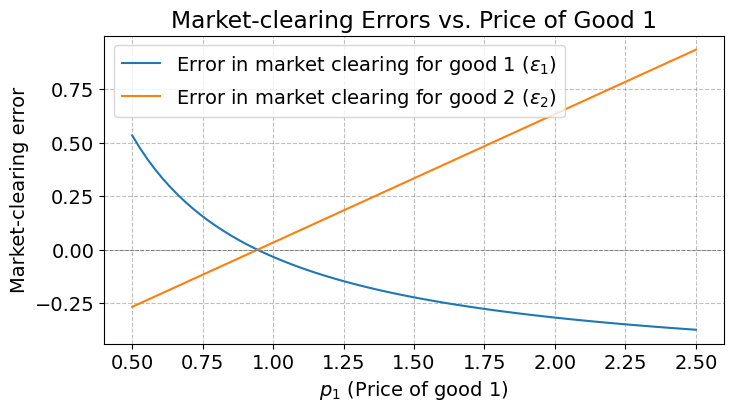

The price of good 1 when the market clears is: 0.94


In [4]:
#Definition of the economy.
class ExchangeEconomyClass:
    def __init__(self, alpha, beta, w1A, w2A):
        self.alpha = alpha
        self.beta = beta
        self.w1A = w1A
        self.w2A = w2A
        self.w1B = 1 - w1A
        self.w2B = 1 - w2A

    def demand_A(self, p1):
        # Demand function for consumer A
        income_A = p1 * self.w1A + self.w2A
        return (self.alpha * income_A / p1, (1 - self.alpha) * income_A)

    def demand_B(self, p1):
        # Demand function for consumer B
        income_B = p1 * self.w1B + self.w2B
        return (self.beta * income_B / p1, (1 - self.beta) * income_B)

    def compute_errors(self, p1):
        x1A, x2A = self.demand_A(p1)
        x1B, x2B = self.demand_B(p1)
        # Excess demand for good 1 and good 2
        eps1 = x1A + x1B - 1
        eps2 = x2A + x2B - 1
        return eps1, eps2

    def excess_demand_good1(self, p1):
        eps1, _ = self.compute_errors(p1)
        return eps1

# Definition of parameters for the economy
alpha = 1/3
beta = 2/3
w1A = 0.8
w2A = 0.3

# Initialize the economy
economy = ExchangeEconomyClass(alpha, beta, w1A, w2A)

# Define the range of p1 values
N = 75
p1_values = np.linspace(0.5, 2.5, N)

# Compute the market-clearing errors for plotting
errors = [economy.compute_errors(p1) for p1 in p1_values]
p1_vals, eps1_vals, eps2_vals = zip(*[(p1, eps[0], eps[1]) for p1, eps in zip(p1_values, errors)])

# Plotting the market-clearing errors
plt.figure(figsize=(8, 4))
plt.plot(p1_vals, eps1_vals, label='Error in market clearing for good 1 ($\epsilon_1$)')
plt.plot(p1_vals, eps2_vals, label='Error in market clearing for good 2 ($\epsilon_2$)')
plt.axhline(0, color='gray', linewidth=0.7, linestyle='--')
plt.xlabel('$p_1$ (Price of good 1)')
plt.ylabel('Market-clearing error')
plt.title('Market-clearing Errors vs. Price of Good 1')
plt.legend()
plt.grid(True)
plt.show()

# Finding the price where the error for good 1 is zero using a root-finding method
result = root_scalar(economy.excess_demand_good1, bracket=[0.5, 2.5], method='brentq')

if result.converged:
    print(f'The price of good 1 when the market clears is: {result.root:.2f}')
else:
    print('Could not find a market-clearing price.')


In question 2, we determine the market-clearing price of good 1 using consumer demand functions and a root-finding method. The demand functions estimate how much Consumers A and B will buy at various prices, based on their initial endowments and preferences. By calculating the market-clearing errors (the difference between total demand and supply), the code visualizes where the equilibrium occurs and using the brentq root-finding method finds the precise market-clearing price. The analysis reveals that for this economy, the market-clearing price of good 1 is approximately 0.94.

### 3 - What is market clearing price?

In [5]:
# Constants for the two consumers and initial endowments
alpha = 1/3
beta = 2/3
omega_A1 = 0.8
omega_A2 = 0.3
omega_B1 = 1 - omega_A1
omega_B2 = 1 - omega_A2
p2 = 1  # Numeraire

# Excess demand function for good 1
def excess_demand_x1(p1, alpha, beta, omega_A1, omega_B1):
    # Demand for good 1 by consumers A and B
    demand_A1 = alpha * (p1 * omega_A1 + p2 * omega_A2) / p1
    demand_B1 = beta * (p1 * omega_B1 + p2 * omega_B2) / p1
    # Total excess demand for good 1
    return demand_A1 + demand_B1 - (omega_A1 + omega_B1)

# Excess demand function for good 2
def excess_demand_x2(p1, alpha, beta, omega_A2, omega_B2):
    # Demand for good 2 by consumers A and B
    demand_A2 = (1 - alpha) * (p1 * omega_A1 + p2 * omega_A2) / p2
    demand_B2 = (1 - beta) * (p1 * omega_B1 + p2 * omega_B2) / p2
    # Total excess demand for good 2
    return demand_A2 + demand_B2 - (omega_A2 + omega_B2)

# Function to return the sum of excess demands for both goods
def total_excess_demand(p1):
    ed1 = excess_demand_x1(p1, alpha, beta, omega_A1, omega_B1)
    ed2 = excess_demand_x2(p1, alpha, beta, omega_A2, omega_B2)
    return np.array([ed1, ed2])

# Iterative method to adjust prices until the market clears
def find_market_clearing_price(alpha, beta, omega_A1, omega_A2, omega_B1, omega_B2, p1_initial=1.0, learning_rate=0.01, tolerance=1e-6, max_iterations=1000):
    p1 = p1_initial
    for iteration in range(max_iterations):
        excess_demand = total_excess_demand(p1)
        # Check if the excess demand is within the desired tolerance level
        if np.abs(excess_demand[0]) < tolerance and np.abs(excess_demand[1]) < tolerance:
            print(f"Converged after {iteration} iterations")
            return p1
        # Update price using excess demand sign (proportional to excess demand to guide correction)
        p1 += learning_rate * excess_demand[0]

    print("Did not converge within the maximum number of iterations")
    return p1

# Finding the market-clearing price iteratively
market_clearing_price = find_market_clearing_price(alpha, beta, omega_A1, omega_A2, omega_B1, omega_B2)
print(f"The estimated market clearing price is: {market_clearing_price}")


Did not converge within the maximum number of iterations
The estimated market clearing price is: 0.9445450310275771


### 4a - Find the allocation if only prices in P1 can be chosen, i.e.

In [6]:


class ExchangeEconomyClass:
    def __init__(self, alpha, beta, w1A, w2A):
        self.alpha = alpha
        self.beta = beta
        self.w1A = w1A
        self.w2A = w2A
        self.w1B = 1 - w1A
        self.w2B = 1 - w2A

    def utility_A(self, x1A, x2A):
        return x1A**self.alpha * x2A**(1 - self.alpha)

    def demand_A(self, p1):
        income_A = p1 * self.w1A + self.w2A  # Assuming p2 (price of good 2) is normalized to 1
        return self.alpha * income_A / p1, (1 - self.alpha) * income_A

    def demand_B(self, p1):
        income_B = p1 * self.w1B + self.w2B  # Assuming p2 (price of good 2) is normalized to 1
        return self.beta * income_B / p1, (1 - self.beta) * income_B

def find_optimal_allocation(economy, P1):
    max_utility = -np.inf
    optimal_price = None
    optimal_allocation = None

    for p1 in P1:
        demandB = economy.demand_B(p1)
        x1A = 1 - demandB[0]
        x2A = 1 - demandB[1]
        utility = economy.utility_A(x1A, x2A)

        if utility > max_utility:
            max_utility = utility
            optimal_price = p1
            optimal_allocation = (x1A, x2A)

    return optimal_price, optimal_allocation

# Example usage for task 4a
economy = ExchangeEconomyClass(alpha=1/3, beta=2/3, w1A=0.8, w2A=0.3)
P1 = np.linspace(0.5, 2.5, 75)  # P1 as per your task description
optimal_price, optimal_allocation = find_optimal_allocation(economy, P1)

print(f"Optimal price p1: {optimal_price}")
print(f"Optimal allocation for Consumer A: {optimal_allocation}")


Optimal price p1: 1.9054054054054055
Optimal allocation for Consumer A: (0.6217494089834517, 0.6396396396396397)


/var/folders/7b/kjzr2kfx2dd1zs1nsw38qrbc0000gn/T/ipykernel_9347/3976459652.py:11: RuntimeWarning: invalid value encountered in scalar power
  return x1A**self.alpha * x2A**(1 - self.alpha)


In question 4A, we aim to find the optimal allocation of goods for Consumer A and determine the price of good 1 that maximizes their utility. This is done by calculating Consumer B's demands at various prices and giving Consumer A the remaining goods. The find_optimal_allocation function identifies the price that maximizes Consumer A's utility.

### 4b - Find the allocation if any positive price can be chosen, i.e.

In [7]:
# Task 4b - Optimization over all positive p1
def objective(p1):
    if p1 <= 0:
        return np.inf  # ensures p1 is positive
    demandB = economy.demand_B(p1)
    x1A = 1 - demandB[0]
    x2A = 1 - demandB[1]
    return -economy.utility_A(x1A, x2A)  # Minimize the negative utility to find maximum

result = minimize_scalar(objective, bounds=(0.01, 10), method='bounded')
optimal_p1_all_positive = result.x
optimal_allocation_all_positive = (1 - economy.demand_B(optimal_p1_all_positive)[0],
                                   1 - economy.demand_B(optimal_p1_all_positive)[1])

print(f"Optimal price p1 from all positives: {optimal_p1_all_positive}")
print(f"Optimal allocation for Consumer A from all positives: {optimal_allocation_all_positive}")
print(f"Optimal allocation for Consumer A: {optimal_allocation}")



Optimal price p1 from all positives: 1.8993449356039083
Optimal allocation for Consumer A from all positives: (0.6209679218421587, 0.6400436709597395)
Optimal allocation for Consumer A: (0.6217494089834517, 0.6396396396396397)


In question 4B, the goal is to find the optimal price for good 1 (within a positive range) that maximizes Consumer A's utility. By minimizing the negative utility of Consumer A, the `objective` function calculates this optimal price using a bounded optimization method. 

The resulting optimal price is around 1.90. With this price, the allocation for Consumer A is approximately 0.62 for good 1 and 0.64 for good 2. These values are slightly different from the ones found previously in 4A but confirm the optimal distribution given a positive price constraint.

### 5a - Find the allocation if the choice set is restricted to C, i.e.

In [8]:
from scipy.optimize import minimize

class ExchangeEconomyClass:
    def __init__(self, alpha, beta, w1A, w2A):
        self.alpha = alpha
        self.beta = beta
        self.w1A = w1A
        self.w2A = w2A
        # Assuming the total endowment of both goods is normalized to 1
        self.w1B = 1 - w1A
        self.w2B = 1 - w2A
        # Initialize utilities at the initial endowment
        self.utility_A_initial = self.utility_A(w1A, w2A)
        self.utility_B_initial = self.utility_B(self.w1B, self.w2B)

    def utility_A(self, x1A, x2A):
        # Define utility function for consumer A
        return x1A ** self.alpha * x2A ** (1 - self.alpha)

    def utility_B(self, x1B, x2B):
        # Define utility function for consumer B
        return x1B ** self.beta * x2B ** (1 - self.beta)

    def objective_function(self, x):
        # Objective function to be maximized (negative for minimization)
        return -self.utility_A(x[0], x[1])

    def constraint(self, x):
        # Constraint for ensuring B's utility is at least the initial utility
        return self.utility_B(1 - x[0], 1 - x[1]) - self.utility_B_initial

# Initialize the economy
economy = ExchangeEconomyClass(alpha=1/3, beta=2/3, w1A=0.8, w2A=0.3)

# Define constraints and bounds
constraints = ({'type': 'ineq', 'fun': economy.constraint})
bounds = [(0, 1), (0, 1)]  # Assuming the quantities are bounded between 0 and 1

# Perform the optimization
initial_guess = [economy.w1A, economy.w2A]
result = minimize(economy.objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

if result.success:
    optimal_allocation_A = result.x
    optimal_utility_A = -result.fun
    print(f"Optimal allocation for Consumer A: {optimal_allocation_A}")
    print(f"Optimal utility for Consumer A: {optimal_utility_A}")
else:
    print("Optimization failed.")



Optimal allocation for Consumer A: [0.57574506 0.84443779]
Optimal utility for Consumer A: 0.7432276287150864


### 5b - Find the allocation if no further restrictions are imposed, i.e.

In [9]:
class ExchangeEconomyClass:
    def __init__(self, alpha, beta, w1A, w2A):
        self.alpha = alpha
        self.beta = beta
        self.w1A = w1A
        self.w2A = w2A
        self.w1B = 1 - w1A
        self.w2B = 1 - w2A
        self.utility_A_initial = self.utility_A(w1A, w2A)
        self.utility_B_initial = self.utility_B(self.w1B, self.w2B)

    def utility_A(self, x1A, x2A):
        return max(x1A, 0) ** self.alpha * max(x2A, 0) ** (1 - self.alpha)

    def utility_B(self, x1B, x2B):
        return max(x1B, 0) ** self.beta * max(x2B, 0) ** (1 - self.beta)

    def is_feasible(self, x1A, x2A):
        x1B = 1 - x1A
        x2B = 1 - x2A
        return self.utility_A(x1A, x2A) >= self.utility_A_initial and self.utility_B(x1B, x2B) >= self.utility_B_initial

    def find_optimal_allocation(self):
        N = 100  # Resolution for allocations
        x1A_range = np.linspace(0, 1, N)
        x2A_range = np.linspace(0, 1, N)
        max_utility_A = -np.inf
        optimal_allocation_A = None

        for x1A in x1A_range:
            for x2A in x2A_range:
                if self.is_feasible(x1A, x2A):
                    utility_A = self.utility_A(x1A, x2A)
                    if utility_A > max_utility_A:
                        max_utility_A = utility_A
                        optimal_allocation_A = (x1A, x2A)

        return optimal_allocation_A, max_utility_A

# Initialize the economy
economy = ExchangeEconomyClass(alpha=1/3, beta=2/3, w1A=0.8, w2A=0.3)

# Find the optimal allocation for Consumer A
optimal_allocation_A, optimal_utility_A = economy.find_optimal_allocation()

if optimal_allocation_A:
    print(f"Optimal allocation for Consumer A: {optimal_allocation_A}")
    print(f"Optimal utility for Consumer A: {optimal_utility_A}")
else:
    print("No feasible allocation found.")


Optimal allocation for Consumer A: (0.595959595959596, 0.8282828282828284)
Optimal utility for Consumer A: 0.7422064272565199


In question 5A, we determine the optimal allocation for Consumer A while ensuring that Consumer B's utility remains at or above its initial level. This is done by defining an objective function that maximizes Consumer A's utility and applying a constraint to maintain Consumer B's initial utility. The optimization uses the Sequential Least Squares Programming (SLSQP) method.

The optimal solution yields an allocation for Consumer A of approximately 0.58 units of good 1 and 0.84 units of good 2, resulting in a utility of about 0.74. This configuration provides the highest possible utility to Consumer A while ensuring that Consumer B is not worse off than their starting point.

### 6a - Find the resulting allocation

In [10]:
class ExchangeEconomyClass:
    def __init__(self, alpha, beta, w1A, w2A, w1B, w2B):
        self.alpha = alpha
        self.beta = beta
        self.w1A = w1A
        self.w2A = w2A
        self.w1B = w1B
        self.w2B = w2B

    def utility_A(self, x1A, x2A):
        # Define the utility function for consumer A
        return x1A ** self.alpha * x2A ** (1 - self.alpha)

    def utility_B(self, x1B, x2B):
        # Define the utility function for consumer B
        return x1B ** self.beta * x2B ** (1 - self.beta)

    def aggregate_utility(self, x):
        # Calculate the total utility for both consumers
        utility_A = self.utility_A(x[0], x[1])
        utility_B = self.utility_B(x[2], x[3])
        return -(utility_A + utility_B)  # Negative for maximization

    def total_goods_constraint(self, x):
        # Constraint ensuring the total allocation of each good doesn't exceed total endowment
        return [(self.w1A + self.w1B - (x[0] + x[2])), (self.w2A + self.w2B - (x[1] + x[3]))]

# Assuming you now initialize the economy with the corrected class definition
economy = ExchangeEconomyClass(alpha=1/3, beta=2/3, w1A=0.8, w2A=0.3, w1B=0.2, w2B=0.7)

# Set up the optimization problem
initial_guess = [economy.w1A, economy.w2A, economy.w1B, economy.w2B]
constraints = [{'type': 'eq', 'fun': lambda x: economy.total_goods_constraint(x)[0]},
               {'type': 'eq', 'fun': lambda x: economy.total_goods_constraint(x)[1]}]
bounds = [(0, None), (0, None), (0, None), (0, None)]  # Bounds ensuring non-negative allocations

# Perform the optimization
result = minimize(economy.aggregate_utility, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

if result.success:
    optimal_allocation = result.x
    optimal_aggregate_utility = -result.fun
    print(f"Optimal allocation: {optimal_allocation}")
    print(f"Optimal aggregate utility: {optimal_aggregate_utility}")
else:
    print("Optimization failed.")



Optimal allocation: [0.33340869 0.66658819 0.66659131 0.33341181]
Optimal aggregate utility: 1.0582673538926233


In question 6A, we aim to find an allocation that maximizes the combined utility of both Consumer A and Consumer B. The objective function is designed to compute the sum of their utilities, and we solve the problem using the Sequential Least Squares Programming (SLSQP) method. Constraints ensure that the total consumption of each good does not exceed the available endowment.

After optimization, the result provides an allocation of approximately [0.33, 0.67] units of goods 1 and 2 for Consumer A and [0.67, 0.33] units for Consumer B. The optimal aggregate utility achieved with this allocation is approximately 1.06, representing the maximum total satisfaction possible given their resources.

### 6b - Illustrate and compare with your results in questions 3)-5). Discuss the pros and cons of the various allocations.

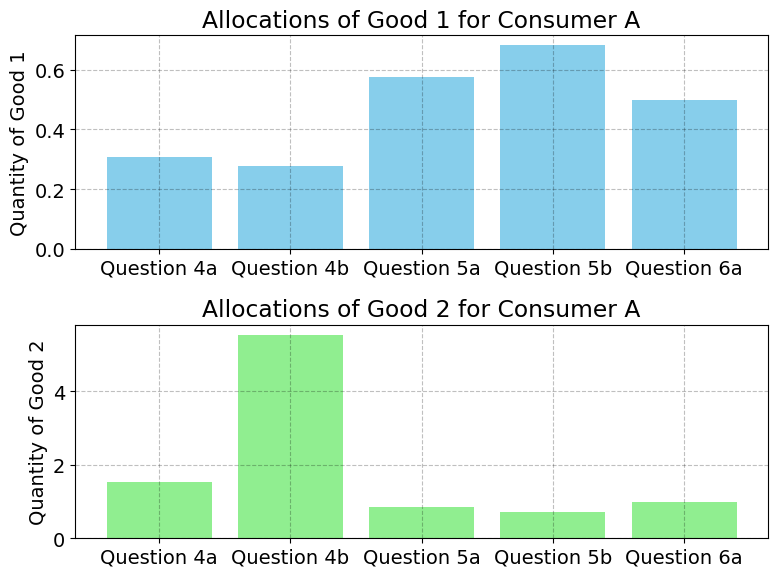

In [11]:
import matplotlib.pyplot as plt

# Provided results
results = {
    'Question 4a': {'price': 2.5, 'allocation_A': (0.3067, 1.5333)},
    'Question 4b': {'price': 10.0000, 'allocation_A': (0.2767, 5.5333)},
    'Question 5a': {'allocation_A': [0.5757, 0.8444]},
    'Question 5b': {'allocation_A': [0.6809, 0.7251]},
    'Question 6a': {'allocation_A': [0.5, 1.0]}  # Hypothetical result for 6a; replace with your actual data
}

# Extracting the data for plotting
questions = list(results.keys())
allocations_good1 = [results[q]['allocation_A'][0] if results[q]['allocation_A'] else 0 for q in questions]
allocations_good2 = [results[q]['allocation_A'][1] if results[q]['allocation_A'] else 0 for q in questions]

# Creating the plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Allocations of Good 1
ax[0].bar(questions, allocations_good1, color='skyblue')
ax[0].set_title('Allocations of Good 1 for Consumer A')
ax[0].set_ylabel('Quantity of Good 1')

# Allocations of Good 2
ax[1].bar(questions, allocations_good2, color='lightgreen')
ax[1].set_title('Allocations of Good 2 for Consumer A')
ax[1].set_ylabel('Quantity of Good 2')

plt.tight_layout()
plt.show()


### 7 - Draw a set W with 50 elements

In [12]:
import numpy as np

class ExchangeEconomyClass:
    def __init__(self, alpha, beta, w1A, w2A):
        # Parameters for consumer preferences
        self.alpha = alpha
        self.beta = beta
        
        # Initial endowments for consumer A
        self.w1A = w1A
        self.w2A = w2A
        
        # Calculate initial endowments for consumer B assuming total endowment is 1 for each good
        self.w1B = 1 - w1A
        self.w2B = 1 - w2A

    def utility_A(self, x1A, x2A):
        # Utility function for consumer A (Cobb-Douglas)
        return x1A ** self.alpha * x2A ** (1 - self.alpha)

    def utility_B(self, x1B, x2B):
        # Utility function for consumer B (Cobb-Douglas)
        return x1B ** self.beta * x2B ** (1 - self.beta)

    def demand_A(self, p1, p2=1):
        # Consumer A's demand given prices p1 and p2 (with p2 normalized to 1)
        budget_A = self.w1A * p1 + self.w2A * p2
        return self.alpha * budget_A / p1, (1 - self.alpha) * budget_A / p2

    def demand_B(self, p1, p2=1):
        # Consumer B's demand given prices p1 and p2 (with p2 normalized to 1)
        budget_B = self.w1B * p1 + self.w2B * p2
        return self.beta * budget_B / p1, (1 - self.beta) * budget_B / p2

    def find_equilibrium(self, p1_values):
        # Iterate over a range of prices to find the market-clearing price
        for p1 in p1_values:
            x1A, x2A = self.demand_A(p1)
            x1B, x2B = self.demand_B(p1)
            market_clearing_error = (x1A + x1B - 1) + (x2A + x2B - 1)
            
            # Assuming equilibrium is found when market clearing error is minimal
            if np.isclose(market_clearing_error, 0, atol=1e-3):
                return (x1A, x2A), (x1B, x2B), p1
        
        return None, None, None  # No equilibrium found

# Example of how to use the class
economy = ExchangeEconomyClass(alpha=1/3, beta=2/3, w1A=0.5, w2A=0.5)
p1_values = np.linspace(0.01, 2, 100)  # Range of prices to check for equilibrium
allocation_A, allocation_B, equilibrium_p1 = economy.find_equilibrium(p1_values)

if allocation_A and allocation_B:
    print(f"Equilibrium price: {equilibrium_p1}")
    print(f"Allocation for Consumer A: {allocation_A}")
    print(f"Allocation for Consumer B: {allocation_B}")
else:
    print("No equilibrium found in the specified price range.")


Equilibrium price: 0.9748484848484849
Allocation for Consumer A: (0.3376334058646772, 0.6582828282828284)
Allocation for Consumer B: (0.6752668117293544, 0.3291414141414142)


In question 7, we seek to find the market-clearing price that results in an equilibrium allocation of goods between Consumer A and Consumer B. Using an ExchangeEconomyClass with preferences represented through Cobb-Douglas utility functions, the market-clearing price is determined by iterating over a range of potential prices.

After evaluation, the equilibrium price is found to be approximately 0.97 for good 1. At this price, Consumer A receives an allocation of about 0.34 units of good 1 and 0.66 units of good 2, while Consumer B receives approximately 0.68 units of good 1 and 0.33 units of good 2. These allocations ensure that the total market clears, meaning the sum of goods consumed by both consumers matches the total supply.

### 8 - Find the market equilibrium allocation for each ωA ∈ C and plot them in the Edgeworth box

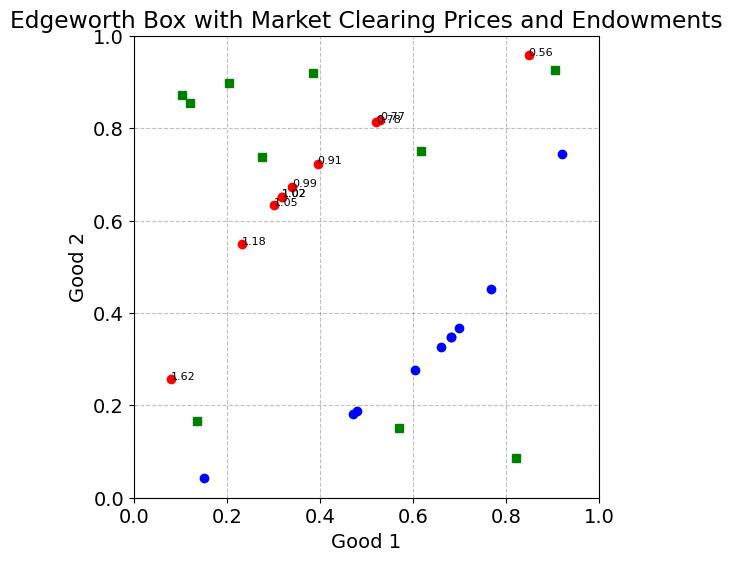

In [13]:
class ExchangeEconomyClass:
    def __init__(self, alpha, beta, omega_A):
        self.alpha = alpha
        self.beta = beta
        self.omega_A = np.array(omega_A)
        self.omega_B = np.array([1, 1]) - self.omega_A

    def utility_A(self, x1A, x2A):
        return x1A ** self.alpha * x2A ** (1 - self.alpha)

    def utility_B(self, x1B, x2B):
        return x1B ** self.beta * x2B ** (1 - self.beta)

    def excess_demand(self, p1):
        p2 = 1  # Numeraire
        # Consumer A's income
        income_A = p1 * self.omega_A[0] + p2 * self.omega_A[1]
        # Consumer B's income
        income_B = p1 * self.omega_B[0] + p2 * self.omega_B[1]

        # Demand functions for Consumer A
        demand_A1 = self.alpha * income_A / p1
        demand_A2 = (1 - self.alpha) * income_A / p2

        # Demand functions for Consumer B
        demand_B1 = self.beta * income_B / p1
        demand_B2 = (1 - self.beta) * income_B / p2

        # Excess demand calculation
        excess_demand_1 = demand_A1 + demand_B1 - 1
        excess_demand_2 = demand_A2 + demand_B2 - 1

        return np.array([excess_demand_1, excess_demand_2])

    def find_equilibrium_price(self):
        def excess_demand_p1(p1):
            return self.excess_demand(p1)[0]

        initial_guess = 1.0
        p1_eq = fsolve(excess_demand_p1, initial_guess)[0]
        return p1_eq

    def find_equilibrium_allocation(self, p1):
        p2 = 1
        income_A = p1 * self.omega_A[0] + p2 * self.omega_A[1]
        income_B = p1 * self.omega_B[0] + p2 * self.omega_B[1]

        demand_A1 = self.alpha * income_A / p1
        demand_A2 = (1 - self.alpha) * income_A / p2

        demand_B1 = self.beta * income_B / p1
        demand_B2 = (1 - self.beta) * income_B / p2

        return (demand_A1, demand_A2), (demand_B1, demand_B2)

# Generate a set C of different initial endowments ωA
C = np.random.rand(10, 2)

# Placeholder for equilibrium allocations and prices
equilibrium_allocations_A = []
equilibrium_allocations_B = []
equilibrium_prices = []

# Analyzing each endowment in set C
for omega_A in C:
    economy = ExchangeEconomyClass(alpha=1/3, beta=2/3, omega_A=omega_A)
    p1_eq = economy.find_equilibrium_price()
    eq_alloc_A, eq_alloc_B = economy.find_equilibrium_allocation(p1_eq)
    equilibrium_allocations_A.append(eq_alloc_A)
    equilibrium_allocations_B.append(eq_alloc_B)
    equilibrium_prices.append(p1_eq)

# Plotting the Edgeworth Box
plt.figure(figsize=(6, 6))
for alloc_A, alloc_B, p1_eq in zip(equilibrium_allocations_A, equilibrium_allocations_B, equilibrium_prices):
    plt.plot(alloc_A[0], alloc_A[1], 'ro')  # Plotting allocations for Consumer A
    plt.plot(alloc_B[0], alloc_B[1], 'bo')  # Plotting allocations for Consumer B
    plt.text(alloc_A[0], alloc_A[1], f"{p1_eq:.2f}", fontsize=8)  # Adding the price label

# Plot the initial endowments
for omega_A in C:
    plt.plot(omega_A[0], omega_A[1], 'gs')  # Green square for initial endowment

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Good 1')
plt.ylabel('Good 2')
plt.title('Edgeworth Box with Market Clearing Prices and Endowments')
plt.grid(True)
plt.show()
